In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [2]:
%run srcnn.py

In [3]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10571219407161533985
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3343777792
locality {
  bus_id: 1
}
incarnation: 1900347447780210350
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


### Load images

In [4]:
PATH = ""
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
TEST_FILE = PATH +"datasets/DIV2K_train_LR_wild/"
VALID_HR = PATH +"datasets/DIV2K_valid_HR/"
VALID_LR = PATH +"datasets/DIV2K_valid_LR_wild/"
obj_files = listdir(TRAIN_FILE )
valid_files = listdir(VALID_HR )

In [5]:
valid_files[:5]

['0844.png', '0881.png', '0873.png', '0878.png', '0813.png']

In [6]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [7]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,64): #should be replaced here with something random at some point
    n = obj_files[i]
    m = valid_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))
    train_img.append(Image.open(TEST_FILE + n[:-4]+"x4w1.png"))
    
    valid_hr_img.append(Image.open(VALID_HR +  m))
    valid_lr_img.append(Image.open(VALID_LR + m[:-4]+"x4w.png"))
#Only consider the luminance channel (YCrCb)
ycbcr_obj = convertToYCbCr(obj_img)
ycbcr_train = convertToYCbCr(train_img)
ycbr_valid_hr = convertToYCbCr(valid_hr_img)
ycbr_valid_lr = convertToYCbCr(valid_lr_img)

In [8]:
ycbcr_obj[0].size

(2040, 1356)

In [9]:
#Display images
def print_luminance(img, ch=3) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [10]:
#Convert images to numpy array
imgs_label = [np.asarray(image) for image in ycbcr_obj]
imgs_train = [np.asarray(image) for image in ycbcr_train]
imgs_valid_hr = [np.asarray(image) for image in ycbr_valid_hr]
imgs_valid_lr = [np.asarray(image) for image in ycbr_valid_lr]


In [11]:
imgs_label[0].shape

(1356, 2040, 3)

(1356, 2040, 3)


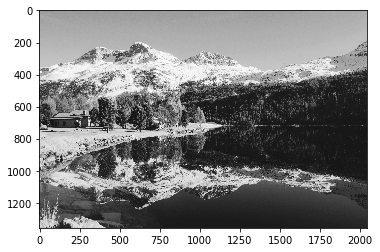

In [12]:
print(imgs_label[1].shape)
print_luminance(imgs_label[1])

(339, 510, 3)


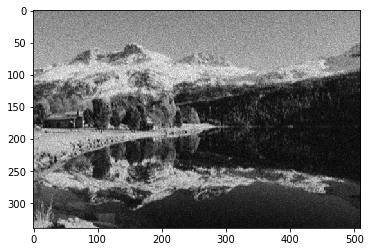

In [13]:
print(imgs_train[1].shape)
print_luminance(imgs_train[1])

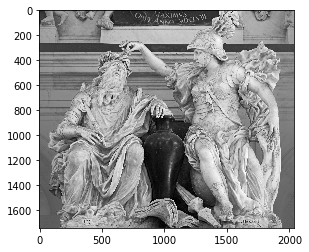

In [14]:
print_luminance(imgs_valid_hr[3])

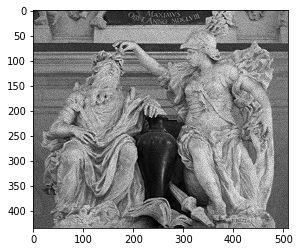

In [15]:
print_luminance(imgs_valid_lr[3])

### Generate train and test set

In [16]:
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height // 2 + centerX*len_interval : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]

In [17]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [18]:
#Division by 4
window_size= 32 
scale = 4
subimages_per_axis = 4

In [19]:
sub_labels = []
sub_samples = []
sub_valid_hr = []
sub_valid_lr = []

for i in range(0,50) :
    label = imgs_label[i]
    shape = imgs_train[i].shape
    s = cv2.resize(imgs_train[i], dsize = (shape[1]*4, shape[0]*4), interpolation = cv2.INTER_CUBIC)
    
    valid_hr = imgs_valid_hr[i]
    shape_lr = imgs_valid_lr[i].shape
    valid_lr = cv2.resize(imgs_valid_lr[i], dsize = (shape_lr[1]*4, shape_lr[0]*4), interpolation = cv2.INTER_CUBIC)
    
    height_label, width_label = retSize(label)
    height_sample, width_sample = retSize(s)
    height_hr, width_hr = retSize(valid_hr)
    height_vlr, width_vlr = retSize(valid_lr)
    
    len_interval = height_sample//subimages_per_axis
    #Calculate subimages
    for j in range(-subimages_per_axis//2, subimages_per_axis//2):
        for k in range(-subimages_per_axis//2, subimages_per_axis//2):
            sub_labels.append(getSubImage(label, height_label, width_label,j,k,len_interval))
            sub_samples.append(getSubImage(s, height_sample, width_sample,j,k,len_interval))

            sub_valid_hr.append(getSubImage(valid_hr, height_hr,width_hr,j,k,len_interval))

            sub_valid_lr.append(getSubImage(valid_lr, height_vlr, width_vlr,j,k,len_interval))

In [20]:
len(sub_labels)

800

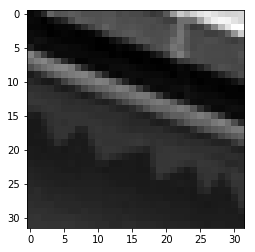

In [21]:
print_luminance(sub_labels[6])

(32, 32, 3)

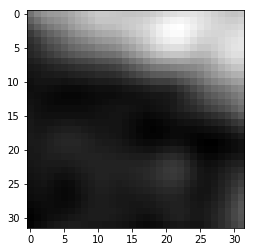

In [22]:
print_luminance(sub_samples[6])
sub_samples[1].shape

(32, 32, 3)

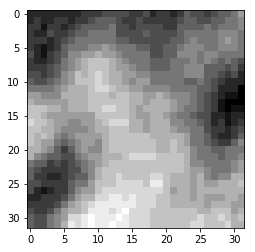

In [23]:
print_luminance(sub_valid_hr[7])
sub_valid_hr[1].shape

(32, 32, 3)

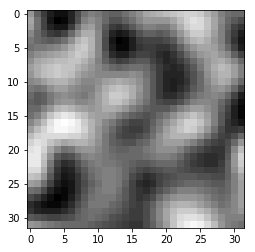

In [24]:
print_luminance(sub_valid_lr[7])
sub_valid_lr[1].shape

#### Generate the wavelets subbands

In [25]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [26]:
y_sample = sub_labels[-1]
x_sample = sub_samples[-1]
print(y_sample.shape)
print(x_sample.shape)

(32, 32, 3)
(32, 32, 3)


In [27]:
def plot_waveletTrans(wt, ch=1) :
    fig = plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    plt.title("Average")
    print_luminance(wt[0], ch )
    plt.subplot(222)
    print_luminance(wt[1][0], ch)
    plt.subplot(223)
    print_luminance(wt[1][1], ch)
    plt.subplot(224)
    print_luminance(wt[1][2], ch)

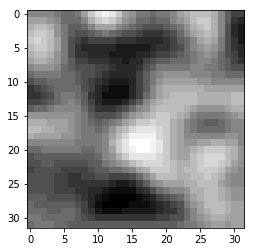

In [28]:
print_luminance(x_sample)

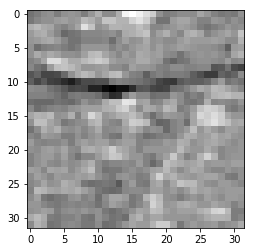

In [29]:
print_luminance(y_sample)

(21, 21)


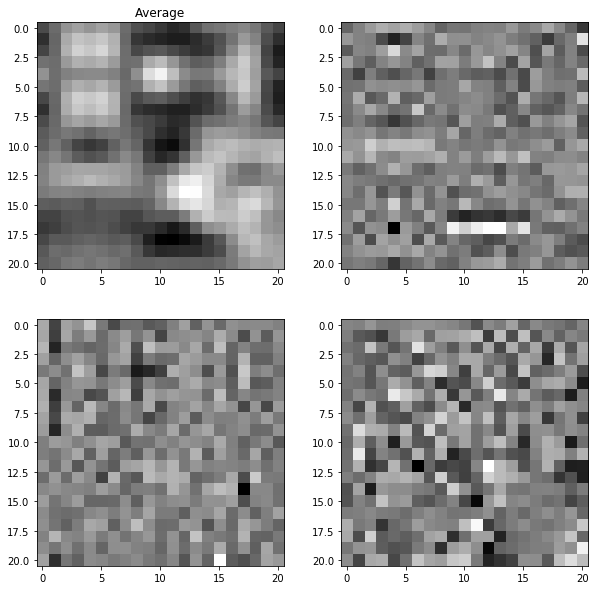

In [30]:
x_dwt = pywt.dwt2(x_sample[:,:, 0], 'db6')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

(21, 21)


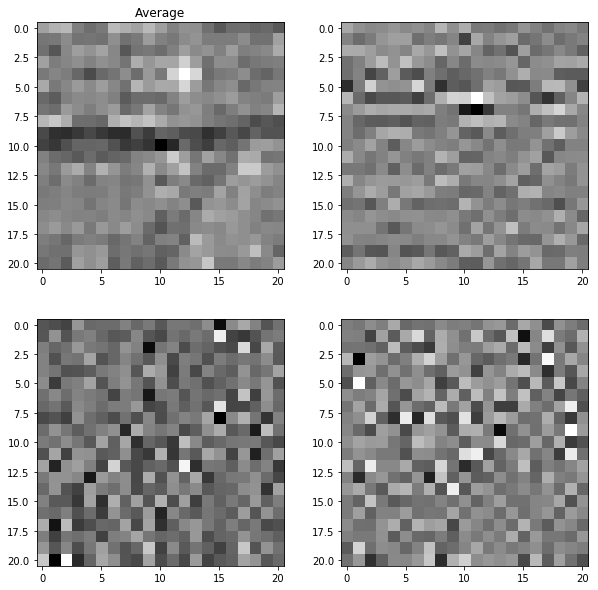

In [31]:
y_dwt = pywt.dwt2(y_sample[:,:, 0], 'db6')
print(y_dwt[0].shape)
plot_waveletTrans(y_dwt)

In [32]:
y_ll = []
y_lh = []
y_hl = []
y_hh = []

x_ll = []
x_lh = []
x_hl = []
x_hh = []

dwt_shape = []
dwt_hr_shape = []

valid_y_ll = []
valid_y_lh = []
valid_y_hl = []
valid_y_hh = []

valid_x_ll = []
valid_x_lh = []
valid_x_hl = []
valid_x_hh = []


for i,y in enumerate(sub_labels):
    x = sub_samples[i]
    vy = sub_valid_hr[i]
    vx = sub_valid_lr[i]
    
    dwt_y = pywt.dwt2(y[:, :, 0], 'db6')
    dwt_x = pywt.dwt2(x[:, :, 0], 'db6')
    dwt_hr = pywt.dwt2(vy[:, :, 0], 'db6')
    dwt_lr = pywt.dwt2(vx[:, :, 0], 'db6')
    
    y_ll, y_lh, y_hl, y_hh = appendSubbands(y_ll, y_lh, y_hl, y_hh, dwt_y)
    x_ll, x_lh, x_hl, x_hh = appendSubbands(x_ll, x_lh, x_hl, x_hh, dwt_x)

    valid_y_ll, valid_y_lh, valid_y_hl, valid_y_hh = appendSubbands(valid_y_ll, 
                                                                    valid_y_lh, 
                                                                    valid_y_hl, 
                                                                    valid_y_hh, dwt_hr)

    valid_x_ll, valid_x_lh, valid_x_hl, valid_x_hh = appendSubbands(valid_x_ll, 
                                                                    valid_x_lh, 
                                                                    valid_x_hl, 
                                                                    valid_x_hh, dwt_lr)
dwt_shape = dwt_x[0].shape
dwt_hr_shape = dwt_y[0].shape

#### Creating and Training the networks

In [33]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

In [34]:
img_rows = dwt_shape[0]
img_cols = dwt_shape[1]

channel = K.image_data_format()

x_train = reshape(x_ll, dwt_shape, channel)
y_train = reshape(y_ll, dwt_hr_shape, channel)
x_test = reshape(valid_x_ll, dwt_shape, channel)
y_test = reshape(valid_y_ll, dwt_hr_shape, channel)
input_shape_ = (img_rows, img_cols, 1)

In [43]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3),strides=(1,1),padding='same',
                 activation='selu',
                 input_shape=input_shape_))

model.add(Conv2D(128, (3, 3),strides=(1,1), activation='selu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(1, (3, 3),strides=(1,1), activation='selu', padding='same'))

model.compile(optimizer=Adam(),
         loss='mean_absolute_percentage_error',
         metrics=[psnr])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 21, 21, 128)       1280      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 21, 21, 128)       512       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 1)         1153      
Total params: 150,529
Trainable params: 150,273
Non-trainable params: 256
_________________________________________________________________


In [45]:
history_CNN = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2000, batch_size=64, verbose=1)

Train on 800 samples, validate on 800 samples
Epoch 1/2000
800/800 [==============================] - 1s 897us/step - loss: 92.2446 - psnr: -111.1380 - val_loss: 6985582.9436 - val_psnr: -110.4456
Epoch 2/2000
800/800 [==============================] - 1s 808us/step - loss: 90.1050 - psnr: -111.1203 - val_loss: 6584184.1132 - val_psnr: -110.5384
Epoch 3/2000
800/800 [==============================] - 1s 786us/step - loss: 89.1014 - psnr: -111.0784 - val_loss: 11718792.4770 - val_psnr: -110.2617
Epoch 4/2000
800/800 [==============================] - 1s 781us/step - loss: 90.5972 - psnr: -110.9549 - val_loss: 10936376.0772 - val_psnr: -109.3292
Epoch 5/2000
800/800 [==============================] - 1s 800us/step - loss: 88.3302 - psnr: -110.9911 - val_loss: 8564999.9556 - val_psnr: -110.4457
Epoch 6/2000
800/800 [==============================] - 1s 836us/step - loss: 87.3450 - psnr: -110.9830 - val_loss: 10934314.4201 - val_psnr: -110.2336
Epoch 7/2000
800/800 [=======================

800/800 [==============================] - 1s 786us/step - loss: 57.1554 - psnr: -101.7544 - val_loss: 31030330.3397 - val_psnr: -93.1976
Epoch 55/2000
800/800 [==============================] - 1s 778us/step - loss: 54.8568 - psnr: -101.3591 - val_loss: 30492968.7109 - val_psnr: -94.8026
Epoch 56/2000
800/800 [==============================] - 1s 784us/step - loss: 52.9855 - psnr: -101.0859 - val_loss: 27665836.5478 - val_psnr: -94.3637
Epoch 57/2000
800/800 [==============================] - 1s 798us/step - loss: 52.3109 - psnr: -100.6869 - val_loss: 25003124.1912 - val_psnr: -95.1149
Epoch 58/2000
800/800 [==============================] - 1s 785us/step - loss: 50.0837 - psnr: -100.3914 - val_loss: 22881683.5004 - val_psnr: -93.9541
Epoch 59/2000
800/800 [==============================] - 1s 781us/step - loss: 49.8539 - psnr: -99.9214 - val_loss: 23364718.0321 - val_psnr: -94.5013
Epoch 60/2000
800/800 [==============================] - 1s 774us/step - loss: 47.7897 - psnr: -99.4031

800/800 [==============================] - 1s 840us/step - loss: 41.1556 - psnr: -86.9416 - val_loss: 12596405.4468 - val_psnr: -90.6020
Epoch 109/2000
800/800 [==============================] - 1s 826us/step - loss: 42.1674 - psnr: -86.5564 - val_loss: 21260733.9080 - val_psnr: -85.9832
Epoch 110/2000
800/800 [==============================] - 1s 818us/step - loss: 40.7802 - psnr: -85.9558 - val_loss: 21733266.1633 - val_psnr: -85.2147
Epoch 111/2000
800/800 [==============================] - 1s 839us/step - loss: 38.8056 - psnr: -85.6329 - val_loss: 19301540.1247 - val_psnr: -86.5492
Epoch 112/2000
800/800 [==============================] - 1s 814us/step - loss: 38.6223 - psnr: -85.6592 - val_loss: 18861814.9207 - val_psnr: -86.4412
Epoch 113/2000
800/800 [==============================] - 1s 827us/step - loss: 36.5474 - psnr: -85.3606 - val_loss: 19918367.1919 - val_psnr: -85.6211
Epoch 114/2000
800/800 [==============================] - 1s 830us/step - loss: 37.2199 - psnr: -85.494

800/800 [==============================] - 1s 788us/step - loss: 34.7018 - psnr: -84.6614 - val_loss: 13400224.2769 - val_psnr: -89.4520
Epoch 163/2000
800/800 [==============================] - 1s 783us/step - loss: 35.9151 - psnr: -84.9784 - val_loss: 14792374.6204 - val_psnr: -87.3992
Epoch 164/2000
800/800 [==============================] - 1s 786us/step - loss: 34.2349 - psnr: -84.6027 - val_loss: 14453249.4553 - val_psnr: -88.1717
Epoch 165/2000
800/800 [==============================] - 1s 785us/step - loss: 34.7123 - psnr: -84.6385 - val_loss: 13896769.5152 - val_psnr: -88.4530
Epoch 166/2000
800/800 [==============================] - 1s 782us/step - loss: 34.3929 - psnr: -84.7961 - val_loss: 13796250.4125 - val_psnr: -88.2275
Epoch 167/2000
800/800 [==============================] - 1s 784us/step - loss: 34.9745 - psnr: -84.7360 - val_loss: 14066887.9446 - val_psnr: -87.4206
Epoch 168/2000
800/800 [==============================] - 1s 785us/step - loss: 33.2057 - psnr: -84.417

Epoch 216/2000
800/800 [==============================] - 1s 786us/step - loss: 32.3615 - psnr: -83.6167 - val_loss: 10182857.3042 - val_psnr: -90.7429
Epoch 217/2000
800/800 [==============================] - 1s 785us/step - loss: 32.7685 - psnr: -83.7205 - val_loss: 11997160.1450 - val_psnr: -88.1130
Epoch 218/2000
800/800 [==============================] - 1s 783us/step - loss: 32.9766 - psnr: -83.7690 - val_loss: 12144085.3977 - val_psnr: -88.4906
Epoch 219/2000
800/800 [==============================] - 1s 785us/step - loss: 32.3846 - psnr: -83.6715 - val_loss: 11472661.4666 - val_psnr: -89.5338
Epoch 220/2000
800/800 [==============================] - 1s 787us/step - loss: 40.8640 - psnr: -83.7872 - val_loss: 14809277.0829 - val_psnr: -85.8612
Epoch 221/2000
800/800 [==============================] - 1s 786us/step - loss: 36.1681 - psnr: -84.1316 - val_loss: 25890063.5173 - val_psnr: -83.7409
Epoch 222/2000
800/800 [==============================] - 1s 783us/step - loss: 37.1897 

Epoch 270/2000
800/800 [==============================] - 1s 800us/step - loss: 32.2905 - psnr: -83.3069 - val_loss: 16701981.5369 - val_psnr: -82.9050
Epoch 271/2000
800/800 [==============================] - 1s 785us/step - loss: 32.7253 - psnr: -83.2743 - val_loss: 14449721.5826 - val_psnr: -84.1067
Epoch 272/2000
800/800 [==============================] - 1s 785us/step - loss: 32.4601 - psnr: -83.3741 - val_loss: 14005657.6402 - val_psnr: -84.7605
Epoch 273/2000
800/800 [==============================] - 1s 784us/step - loss: 32.7737 - psnr: -83.3145 - val_loss: 13600414.5502 - val_psnr: -84.7751
Epoch 274/2000
800/800 [==============================] - 1s 784us/step - loss: 33.0671 - psnr: -83.4958 - val_loss: 14952546.9843 - val_psnr: -83.6143
Epoch 275/2000
800/800 [==============================] - 1s 826us/step - loss: 34.2601 - psnr: -83.6939 - val_loss: 15096980.5095 - val_psnr: -83.6922
Epoch 276/2000
800/800 [==============================] - 1s 843us/step - loss: 32.1938 

Epoch 324/2000
800/800 [==============================] - 1s 788us/step - loss: 33.9633 - psnr: -83.3947 - val_loss: 21036708.6091 - val_psnr: -83.7596
Epoch 325/2000
800/800 [==============================] - 1s 784us/step - loss: 33.3108 - psnr: -83.3192 - val_loss: 15939247.9751 - val_psnr: -84.2847
Epoch 326/2000
800/800 [==============================] - 1s 784us/step - loss: 33.0179 - psnr: -83.5658 - val_loss: 15622401.4609 - val_psnr: -83.2814
Epoch 327/2000
800/800 [==============================] - 1s 784us/step - loss: 31.4578 - psnr: -83.1889 - val_loss: 12380951.9358 - val_psnr: -85.6345
Epoch 328/2000
800/800 [==============================] - 1s 786us/step - loss: 32.8786 - psnr: -83.6325 - val_loss: 13469072.4554 - val_psnr: -84.7623
Epoch 329/2000
800/800 [==============================] - 1s 785us/step - loss: 33.6638 - psnr: -83.4807 - val_loss: 14088455.2535 - val_psnr: -84.8096
Epoch 330/2000
800/800 [==============================] - 1s 783us/step - loss: 32.4797 

Epoch 378/2000
800/800 [==============================] - 1s 782us/step - loss: 38.1258 - psnr: -83.6665 - val_loss: 36898782.7473 - val_psnr: -92.4999
Epoch 379/2000
800/800 [==============================] - 1s 783us/step - loss: 35.2675 - psnr: -82.7790 - val_loss: 27233638.3592 - val_psnr: -83.8292
Epoch 380/2000
800/800 [==============================] - 1s 785us/step - loss: 33.1322 - psnr: -82.5809 - val_loss: 22252268.5439 - val_psnr: -82.1554
Epoch 381/2000
800/800 [==============================] - 1s 785us/step - loss: 32.3002 - psnr: -82.5131 - val_loss: 19019954.4528 - val_psnr: -82.4215
Epoch 382/2000
800/800 [==============================] - 1s 782us/step - loss: 32.9630 - psnr: -83.2256 - val_loss: 16436717.2863 - val_psnr: -82.7194
Epoch 383/2000
800/800 [==============================] - 1s 785us/step - loss: 32.3788 - psnr: -82.8212 - val_loss: 14831419.5841 - val_psnr: -83.0426
Epoch 384/2000
800/800 [==============================] - 1s 785us/step - loss: 32.4287 

Epoch 432/2000
800/800 [==============================] - 1s 815us/step - loss: 32.1015 - psnr: -82.4349 - val_loss: 14826013.3343 - val_psnr: -83.7121
Epoch 433/2000
800/800 [==============================] - 1s 854us/step - loss: 32.5660 - psnr: -82.6649 - val_loss: 12960077.6464 - val_psnr: -85.8501
Epoch 434/2000
800/800 [==============================] - 1s 856us/step - loss: 33.1732 - psnr: -82.7447 - val_loss: 13454335.7216 - val_psnr: -86.0195
Epoch 435/2000
800/800 [==============================] - 1s 854us/step - loss: 33.6025 - psnr: -82.7814 - val_loss: 17687271.1095 - val_psnr: -82.4749
Epoch 436/2000
800/800 [==============================] - 1s 852us/step - loss: 34.9011 - psnr: -82.6665 - val_loss: 18544741.3697 - val_psnr: -82.9217
Epoch 437/2000
800/800 [==============================] - 1s 853us/step - loss: 34.3788 - psnr: -82.3907 - val_loss: 13634868.7789 - val_psnr: -84.6232
Epoch 438/2000
800/800 [==============================] - 1s 856us/step - loss: 34.8188 

Epoch 486/2000
800/800 [==============================] - 1s 848us/step - loss: 31.2002 - psnr: -83.1035 - val_loss: 15925294.2452 - val_psnr: -82.4376
Epoch 487/2000
800/800 [==============================] - 1s 856us/step - loss: 31.7118 - psnr: -82.9148 - val_loss: 14629285.9987 - val_psnr: -83.3474
Epoch 488/2000
800/800 [==============================] - 1s 802us/step - loss: 31.9562 - psnr: -82.9058 - val_loss: 16825166.1356 - val_psnr: -82.4875
Epoch 489/2000
800/800 [==============================] - 1s 787us/step - loss: 30.4495 - psnr: -82.5627 - val_loss: 14015335.0610 - val_psnr: -83.8408
Epoch 490/2000
800/800 [==============================] - 1s 786us/step - loss: 31.2776 - psnr: -82.8250 - val_loss: 13233388.3911 - val_psnr: -84.2092
Epoch 491/2000
800/800 [==============================] - 1s 784us/step - loss: 30.5326 - psnr: -82.8083 - val_loss: 13110460.8641 - val_psnr: -84.2588
Epoch 492/2000
800/800 [==============================] - 1s 788us/step - loss: 30.9288 

Epoch 540/2000
800/800 [==============================] - 1s 787us/step - loss: 31.3661 - psnr: -83.0473 - val_loss: 12160430.7051 - val_psnr: -85.3891
Epoch 541/2000
800/800 [==============================] - 1s 785us/step - loss: 33.3096 - psnr: -83.5617 - val_loss: 18351969.1813 - val_psnr: -82.7874
Epoch 542/2000
800/800 [==============================] - 1s 784us/step - loss: 31.2848 - psnr: -82.7216 - val_loss: 14143195.5100 - val_psnr: -84.5547
Epoch 543/2000
800/800 [==============================] - 1s 786us/step - loss: 32.8030 - psnr: -82.9134 - val_loss: 15329675.7709 - val_psnr: -82.9607
Epoch 544/2000
800/800 [==============================] - 1s 787us/step - loss: 30.6977 - psnr: -82.6745 - val_loss: 13821412.8959 - val_psnr: -83.3603
Epoch 545/2000
800/800 [==============================] - 1s 785us/step - loss: 31.7891 - psnr: -82.6851 - val_loss: 14700231.8567 - val_psnr: -82.9858
Epoch 546/2000
800/800 [==============================] - 1s 783us/step - loss: 31.4837 

Epoch 594/2000
800/800 [==============================] - 1s 785us/step - loss: 34.2226 - psnr: -83.3596 - val_loss: 22340573.0704 - val_psnr: -83.0877
Epoch 595/2000
800/800 [==============================] - 1s 785us/step - loss: 33.8676 - psnr: -82.7855 - val_loss: 18902162.4052 - val_psnr: -82.2207
Epoch 596/2000
800/800 [==============================] - 1s 788us/step - loss: 31.9889 - psnr: -82.8120 - val_loss: 14049462.3048 - val_psnr: -85.8380
Epoch 597/2000
800/800 [==============================] - 1s 786us/step - loss: 31.7994 - psnr: -83.1539 - val_loss: 14945907.3879 - val_psnr: -83.2355
Epoch 598/2000
800/800 [==============================] - 1s 790us/step - loss: 32.1798 - psnr: -83.2842 - val_loss: 14070242.4166 - val_psnr: -84.2982
Epoch 599/2000
800/800 [==============================] - 1s 787us/step - loss: 32.2564 - psnr: -82.8057 - val_loss: 15185761.4955 - val_psnr: -83.3636
Epoch 600/2000
800/800 [==============================] - 1s 800us/step - loss: 31.5733 

Epoch 648/2000
800/800 [==============================] - 1s 786us/step - loss: 30.7496 - psnr: -82.7753 - val_loss: 13627698.5144 - val_psnr: -85.0113
Epoch 649/2000
800/800 [==============================] - 1s 785us/step - loss: 32.5095 - psnr: -82.9813 - val_loss: 14596316.0836 - val_psnr: -83.7427
Epoch 650/2000
800/800 [==============================] - 1s 785us/step - loss: 30.8375 - psnr: -82.4110 - val_loss: 14347248.5249 - val_psnr: -83.8296
Epoch 651/2000
800/800 [==============================] - 1s 786us/step - loss: 30.6293 - psnr: -82.5926 - val_loss: 15566566.6280 - val_psnr: -82.7122
Epoch 652/2000
800/800 [==============================] - 1s 787us/step - loss: 30.7571 - psnr: -82.7398 - val_loss: 14675240.6598 - val_psnr: -83.3989
Epoch 653/2000
800/800 [==============================] - 1s 787us/step - loss: 31.5074 - psnr: -82.9039 - val_loss: 16089580.1291 - val_psnr: -82.5998
Epoch 654/2000
800/800 [==============================] - 1s 783us/step - loss: 31.5979 

Epoch 702/2000
800/800 [==============================] - 1s 784us/step - loss: 31.2392 - psnr: -82.7479 - val_loss: 17819829.2369 - val_psnr: -83.5255
Epoch 703/2000
800/800 [==============================] - 1s 785us/step - loss: 35.8985 - psnr: -83.1811 - val_loss: 21338625.9795 - val_psnr: -84.8024
Epoch 704/2000
800/800 [==============================] - 1s 785us/step - loss: 34.4113 - psnr: -83.3785 - val_loss: 14565932.8601 - val_psnr: -84.4237
Epoch 705/2000
800/800 [==============================] - 1s 786us/step - loss: 31.6588 - psnr: -83.3921 - val_loss: 15669063.1975 - val_psnr: -82.7056
Epoch 706/2000
800/800 [==============================] - 1s 784us/step - loss: 32.7739 - psnr: -82.9675 - val_loss: 17539173.4659 - val_psnr: -83.8192
Epoch 707/2000
800/800 [==============================] - 1s 786us/step - loss: 31.8640 - psnr: -82.9907 - val_loss: 13107279.8352 - val_psnr: -83.8460
Epoch 708/2000
800/800 [==============================] - 1s 786us/step - loss: 30.8137 

Epoch 756/2000
800/800 [==============================] - 1s 788us/step - loss: 29.6038 - psnr: -82.5670 - val_loss: 14280011.2957 - val_psnr: -83.6510
Epoch 757/2000
800/800 [==============================] - 1s 788us/step - loss: 30.8362 - psnr: -82.6245 - val_loss: 13342172.1558 - val_psnr: -84.3450
Epoch 758/2000
800/800 [==============================] - 1s 787us/step - loss: 31.1564 - psnr: -82.5880 - val_loss: 12258888.9000 - val_psnr: -84.9472
Epoch 759/2000
800/800 [==============================] - 1s 786us/step - loss: 30.8992 - psnr: -82.8875 - val_loss: 14428832.3922 - val_psnr: -82.7921
Epoch 760/2000
800/800 [==============================] - 1s 787us/step - loss: 31.3318 - psnr: -82.9354 - val_loss: 14974963.5394 - val_psnr: -82.7532
Epoch 761/2000
800/800 [==============================] - 1s 788us/step - loss: 30.0735 - psnr: -82.6374 - val_loss: 15121314.0990 - val_psnr: -82.5269
Epoch 762/2000
800/800 [==============================] - 1s 788us/step - loss: 30.2860 

Epoch 810/2000
800/800 [==============================] - 1s 784us/step - loss: 29.9038 - psnr: -82.5219 - val_loss: 11203053.6267 - val_psnr: -84.0768
Epoch 811/2000
800/800 [==============================] - 1s 790us/step - loss: 31.7377 - psnr: -82.7729 - val_loss: 13023342.6759 - val_psnr: -82.9286
Epoch 812/2000
800/800 [==============================] - 1s 791us/step - loss: 30.4151 - psnr: -82.9260 - val_loss: 15250121.9550 - val_psnr: -82.3708
Epoch 813/2000
800/800 [==============================] - 1s 784us/step - loss: 32.9617 - psnr: -82.6024 - val_loss: 23822929.0494 - val_psnr: -84.9043
Epoch 814/2000
800/800 [==============================] - 1s 788us/step - loss: 32.3654 - psnr: -82.6431 - val_loss: 20687368.1249 - val_psnr: -82.1567
Epoch 815/2000
800/800 [==============================] - 1s 788us/step - loss: 31.6640 - psnr: -82.7195 - val_loss: 20128628.6613 - val_psnr: -83.1425
Epoch 816/2000
800/800 [==============================] - 1s 788us/step - loss: 31.0044 

Epoch 864/2000
800/800 [==============================] - 1s 787us/step - loss: 30.8777 - psnr: -82.8929 - val_loss: 14969808.4407 - val_psnr: -83.4021
Epoch 865/2000
800/800 [==============================] - 1s 787us/step - loss: 31.8852 - psnr: -82.9033 - val_loss: 18015572.9332 - val_psnr: -82.0959
Epoch 866/2000
800/800 [==============================] - 1s 787us/step - loss: 31.8417 - psnr: -82.7464 - val_loss: 15498582.6602 - val_psnr: -83.3084
Epoch 867/2000
800/800 [==============================] - 1s 789us/step - loss: 30.7120 - psnr: -83.1598 - val_loss: 13408260.5035 - val_psnr: -84.6198
Epoch 868/2000
800/800 [==============================] - 1s 788us/step - loss: 30.0959 - psnr: -82.9189 - val_loss: 12222655.8265 - val_psnr: -85.1994
Epoch 869/2000
800/800 [==============================] - 1s 785us/step - loss: 30.4270 - psnr: -82.8455 - val_loss: 16786455.7348 - val_psnr: -82.6402
Epoch 870/2000
800/800 [==============================] - 1s 782us/step - loss: 30.8812 

Epoch 918/2000
800/800 [==============================] - 1s 789us/step - loss: 29.6575 - psnr: -83.0126 - val_loss: 12939996.5758 - val_psnr: -84.2146
Epoch 919/2000
800/800 [==============================] - 1s 788us/step - loss: 30.3219 - psnr: -83.1375 - val_loss: 15172566.1935 - val_psnr: -82.7307
Epoch 920/2000
800/800 [==============================] - 1s 786us/step - loss: 29.9051 - psnr: -83.1464 - val_loss: 13804811.1137 - val_psnr: -84.5164
Epoch 921/2000
800/800 [==============================] - 1s 789us/step - loss: 30.6506 - psnr: -82.8442 - val_loss: 17519191.0734 - val_psnr: -82.3344
Epoch 922/2000
800/800 [==============================] - 1s 786us/step - loss: 30.1200 - psnr: -82.4711 - val_loss: 14402301.9980 - val_psnr: -83.2302
Epoch 923/2000
800/800 [==============================] - 1s 786us/step - loss: 29.8492 - psnr: -82.6554 - val_loss: 15397487.4169 - val_psnr: -83.1883
Epoch 924/2000
800/800 [==============================] - 1s 786us/step - loss: 29.6228 

Epoch 972/2000
800/800 [==============================] - 1s 795us/step - loss: 30.7891 - psnr: -82.6239 - val_loss: 12783975.8371 - val_psnr: -85.6121
Epoch 973/2000
800/800 [==============================] - 1s 787us/step - loss: 31.1732 - psnr: -82.7390 - val_loss: 15814471.5045 - val_psnr: -82.6725
Epoch 974/2000
800/800 [==============================] - 1s 786us/step - loss: 30.0350 - psnr: -82.6538 - val_loss: 16098429.4748 - val_psnr: -82.4608
Epoch 975/2000
800/800 [==============================] - 1s 791us/step - loss: 29.5712 - psnr: -82.6283 - val_loss: 14795852.3857 - val_psnr: -83.1848
Epoch 976/2000
800/800 [==============================] - 1s 788us/step - loss: 29.4757 - psnr: -82.7450 - val_loss: 14555764.7979 - val_psnr: -82.9668
Epoch 977/2000
800/800 [==============================] - 1s 792us/step - loss: 30.6213 - psnr: -83.1503 - val_loss: 13809718.9856 - val_psnr: -83.3961
Epoch 978/2000
800/800 [==============================] - 1s 787us/step - loss: 31.0842 

Epoch 1026/2000
800/800 [==============================] - 1s 781us/step - loss: 30.2341 - psnr: -83.0707 - val_loss: 12929167.5733 - val_psnr: -84.4518
Epoch 1027/2000
800/800 [==============================] - 1s 779us/step - loss: 29.7418 - psnr: -83.1235 - val_loss: 12096405.2806 - val_psnr: -85.9610
Epoch 1028/2000
800/800 [==============================] - 1s 777us/step - loss: 31.1833 - psnr: -83.0745 - val_loss: 12168033.3483 - val_psnr: -83.4095
Epoch 1029/2000
800/800 [==============================] - 1s 779us/step - loss: 29.0449 - psnr: -82.6611 - val_loss: 10599843.2203 - val_psnr: -84.3344
Epoch 1030/2000
800/800 [==============================] - 1s 783us/step - loss: 31.6638 - psnr: -82.7744 - val_loss: 15852740.4846 - val_psnr: -82.3443
Epoch 1031/2000
800/800 [==============================] - 1s 784us/step - loss: 29.1417 - psnr: -82.7760 - val_loss: 13000427.1553 - val_psnr: -84.1362
Epoch 1032/2000
800/800 [==============================] - 1s 780us/step - loss: 2

800/800 [==============================] - 1s 782us/step - loss: 29.8129 - psnr: -82.7750 - val_loss: 15058663.0495 - val_psnr: -82.9822
Epoch 1080/2000
800/800 [==============================] - 1s 779us/step - loss: 30.9780 - psnr: -83.5308 - val_loss: 14840519.8823 - val_psnr: -82.7931
Epoch 1081/2000
800/800 [==============================] - 1s 778us/step - loss: 30.6393 - psnr: -83.5910 - val_loss: 12118821.6129 - val_psnr: -84.8298
Epoch 1082/2000
800/800 [==============================] - 1s 781us/step - loss: 29.0673 - psnr: -83.0483 - val_loss: 13007514.2305 - val_psnr: -83.5767
Epoch 1083/2000
800/800 [==============================] - 1s 780us/step - loss: 30.0401 - psnr: -83.0075 - val_loss: 13043662.7018 - val_psnr: -83.3097
Epoch 1084/2000
800/800 [==============================] - 1s 780us/step - loss: 29.8554 - psnr: -82.9419 - val_loss: 12733316.6846 - val_psnr: -84.4659
Epoch 1085/2000
800/800 [==============================] - 1s 778us/step - loss: 29.9019 - psnr: -

Epoch 1133/2000
800/800 [==============================] - 1s 782us/step - loss: 40.3548 - psnr: -82.7494 - val_loss: 19065749.6358 - val_psnr: -86.9806
Epoch 1134/2000
800/800 [==============================] - 1s 778us/step - loss: 33.6363 - psnr: -83.5110 - val_loss: 14290033.8838 - val_psnr: -84.4258
Epoch 1135/2000
800/800 [==============================] - 1s 780us/step - loss: 31.2901 - psnr: -83.8328 - val_loss: 9200641.1596 - val_psnr: -88.2002
Epoch 1136/2000
800/800 [==============================] - 1s 778us/step - loss: 33.1523 - psnr: -83.1258 - val_loss: 25916339.3027 - val_psnr: -89.6338
Epoch 1137/2000
800/800 [==============================] - 1s 782us/step - loss: 33.7583 - psnr: -83.1512 - val_loss: 25345821.6821 - val_psnr: -86.4964
Epoch 1138/2000
800/800 [==============================] - 1s 778us/step - loss: 31.7699 - psnr: -82.4940 - val_loss: 23094025.4402 - val_psnr: -84.2607
Epoch 1139/2000
800/800 [==============================] - 1s 785us/step - loss: 30

800/800 [==============================] - 1s 780us/step - loss: 29.1773 - psnr: -82.6063 - val_loss: 14288315.6544 - val_psnr: -83.0446
Epoch 1187/2000
800/800 [==============================] - 1s 779us/step - loss: 30.1820 - psnr: -82.9789 - val_loss: 14002739.8567 - val_psnr: -83.4248
Epoch 1188/2000
800/800 [==============================] - 1s 778us/step - loss: 28.6611 - psnr: -82.4689 - val_loss: 15007096.1257 - val_psnr: -82.9899
Epoch 1189/2000
800/800 [==============================] - 1s 780us/step - loss: 31.9566 - psnr: -82.9918 - val_loss: 17441939.9459 - val_psnr: -82.2388
Epoch 1190/2000
800/800 [==============================] - 1s 780us/step - loss: 29.1543 - psnr: -82.8191 - val_loss: 14402637.9945 - val_psnr: -83.4227
Epoch 1191/2000
800/800 [==============================] - 1s 779us/step - loss: 29.5211 - psnr: -82.6412 - val_loss: 14399085.9484 - val_psnr: -83.2927
Epoch 1192/2000
800/800 [==============================] - 1s 779us/step - loss: 29.2846 - psnr: -

Epoch 1240/2000
800/800 [==============================] - 1s 776us/step - loss: 28.4635 - psnr: -82.8898 - val_loss: 11995360.5300 - val_psnr: -84.2432
Epoch 1241/2000
800/800 [==============================] - 1s 778us/step - loss: 28.6483 - psnr: -83.1054 - val_loss: 12459792.0592 - val_psnr: -84.2724
Epoch 1242/2000
800/800 [==============================] - 1s 783us/step - loss: 30.1543 - psnr: -83.3919 - val_loss: 13365973.6548 - val_psnr: -83.2948
Epoch 1243/2000
800/800 [==============================] - 1s 778us/step - loss: 29.2766 - psnr: -82.6886 - val_loss: 12395977.7674 - val_psnr: -83.9222
Epoch 1244/2000
800/800 [==============================] - 1s 779us/step - loss: 30.1552 - psnr: -83.2223 - val_loss: 13401160.6455 - val_psnr: -83.2416
Epoch 1245/2000
800/800 [==============================] - 1s 781us/step - loss: 29.9849 - psnr: -83.1434 - val_loss: 13514558.9011 - val_psnr: -83.4647
Epoch 1246/2000
800/800 [==============================] - 1s 779us/step - loss: 2

800/800 [==============================] - 1s 780us/step - loss: 29.4830 - psnr: -83.0994 - val_loss: 14552812.2618 - val_psnr: -83.1146
Epoch 1294/2000
800/800 [==============================] - 1s 777us/step - loss: 29.5768 - psnr: -82.8879 - val_loss: 15492636.4414 - val_psnr: -82.8081
Epoch 1295/2000
800/800 [==============================] - 1s 777us/step - loss: 29.6209 - psnr: -83.1569 - val_loss: 14765841.7371 - val_psnr: -82.9334
Epoch 1296/2000
800/800 [==============================] - 1s 782us/step - loss: 29.0884 - psnr: -82.6273 - val_loss: 13377503.5377 - val_psnr: -84.1522
Epoch 1297/2000
800/800 [==============================] - 1s 778us/step - loss: 29.0539 - psnr: -83.0364 - val_loss: 12654237.8230 - val_psnr: -84.9736
Epoch 1298/2000
800/800 [==============================] - 1s 778us/step - loss: 28.9387 - psnr: -82.9196 - val_loss: 13477839.5604 - val_psnr: -84.0855
Epoch 1299/2000
800/800 [==============================] - 1s 779us/step - loss: 29.0477 - psnr: -

Epoch 1347/2000
800/800 [==============================] - 1s 778us/step - loss: 34.1152 - psnr: -83.3842 - val_loss: 20479878.4105 - val_psnr: -85.5674
Epoch 1348/2000
800/800 [==============================] - 1s 779us/step - loss: 33.1424 - psnr: -83.4615 - val_loss: 17479406.3058 - val_psnr: -83.1058
Epoch 1349/2000
800/800 [==============================] - 1s 778us/step - loss: 30.0733 - psnr: -83.3076 - val_loss: 16697868.3097 - val_psnr: -83.0473
Epoch 1350/2000
800/800 [==============================] - 1s 781us/step - loss: 29.5451 - psnr: -82.7945 - val_loss: 16694134.6815 - val_psnr: -82.6763
Epoch 1351/2000
800/800 [==============================] - 1s 778us/step - loss: 28.8746 - psnr: -82.6532 - val_loss: 15374921.4338 - val_psnr: -82.8559
Epoch 1352/2000
800/800 [==============================] - 1s 782us/step - loss: 28.7126 - psnr: -82.7765 - val_loss: 14842405.9178 - val_psnr: -82.9862
Epoch 1353/2000
800/800 [==============================] - 1s 781us/step - loss: 2

800/800 [==============================] - 1s 781us/step - loss: 28.8255 - psnr: -82.5288 - val_loss: 14620340.3079 - val_psnr: -83.2241
Epoch 1401/2000
800/800 [==============================] - 1s 779us/step - loss: 29.1334 - psnr: -83.0085 - val_loss: 11296338.9156 - val_psnr: -85.3004
Epoch 1402/2000
800/800 [==============================] - 1s 780us/step - loss: 30.9951 - psnr: -83.0033 - val_loss: 18334292.4740 - val_psnr: -82.3680
Epoch 1403/2000
800/800 [==============================] - 1s 780us/step - loss: 29.0108 - psnr: -82.5234 - val_loss: 19145022.1693 - val_psnr: -82.2857
Epoch 1404/2000
800/800 [==============================] - 1s 779us/step - loss: 29.4934 - psnr: -82.9512 - val_loss: 14170971.7094 - val_psnr: -83.5586
Epoch 1405/2000
800/800 [==============================] - 1s 782us/step - loss: 29.7146 - psnr: -83.4216 - val_loss: 10836776.5730 - val_psnr: -84.7932
Epoch 1406/2000
800/800 [==============================] - 1s 779us/step - loss: 29.1702 - psnr: -

Epoch 1454/2000
800/800 [==============================] - 1s 778us/step - loss: 31.6096 - psnr: -83.5035 - val_loss: 14784591.4047 - val_psnr: -83.2719
Epoch 1455/2000
800/800 [==============================] - 1s 776us/step - loss: 28.9156 - psnr: -82.9204 - val_loss: 15026088.4878 - val_psnr: -82.9350
Epoch 1456/2000
800/800 [==============================] - 1s 781us/step - loss: 28.2983 - psnr: -82.4627 - val_loss: 14170255.3529 - val_psnr: -83.1164
Epoch 1457/2000
800/800 [==============================] - 1s 779us/step - loss: 28.7042 - psnr: -82.9747 - val_loss: 13176946.7263 - val_psnr: -84.4130
Epoch 1458/2000
800/800 [==============================] - 1s 779us/step - loss: 28.9116 - psnr: -83.0695 - val_loss: 14422321.7979 - val_psnr: -82.9931
Epoch 1459/2000
800/800 [==============================] - 1s 778us/step - loss: 30.0194 - psnr: -83.4012 - val_loss: 14801631.0757 - val_psnr: -82.8265
Epoch 1460/2000
800/800 [==============================] - 1s 778us/step - loss: 2

800/800 [==============================] - 1s 782us/step - loss: 29.2960 - psnr: -83.1882 - val_loss: 13251173.3077 - val_psnr: -83.4169
Epoch 1508/2000
800/800 [==============================] - 1s 780us/step - loss: 28.6269 - psnr: -82.9679 - val_loss: 12519400.7060 - val_psnr: -83.8437
Epoch 1509/2000
800/800 [==============================] - 1s 778us/step - loss: 29.3798 - psnr: -83.0746 - val_loss: 12875316.3282 - val_psnr: -83.4902
Epoch 1510/2000
800/800 [==============================] - 1s 780us/step - loss: 30.4669 - psnr: -83.1703 - val_loss: 12454760.9706 - val_psnr: -84.3225
Epoch 1511/2000
800/800 [==============================] - 1s 780us/step - loss: 28.0412 - psnr: -82.7030 - val_loss: 13155829.5026 - val_psnr: -83.9830
Epoch 1512/2000
800/800 [==============================] - 1s 780us/step - loss: 29.8293 - psnr: -82.6572 - val_loss: 16682725.7591 - val_psnr: -82.3254
Epoch 1513/2000
800/800 [==============================] - 1s 780us/step - loss: 28.7420 - psnr: -

Epoch 1561/2000
800/800 [==============================] - 1s 781us/step - loss: 28.1148 - psnr: -82.7091 - val_loss: 15926892.5239 - val_psnr: -82.8224
Epoch 1562/2000
800/800 [==============================] - 1s 777us/step - loss: 28.0280 - psnr: -82.7301 - val_loss: 14482145.0615 - val_psnr: -83.6042
Epoch 1563/2000
800/800 [==============================] - 1s 780us/step - loss: 29.2711 - psnr: -83.1164 - val_loss: 15905832.2630 - val_psnr: -82.5733
Epoch 1564/2000
800/800 [==============================] - 1s 780us/step - loss: 28.0607 - psnr: -82.6114 - val_loss: 16320364.4198 - val_psnr: -82.6602
Epoch 1565/2000
800/800 [==============================] - 1s 781us/step - loss: 28.6468 - psnr: -82.7321 - val_loss: 15662584.6064 - val_psnr: -83.4177
Epoch 1566/2000
800/800 [==============================] - 1s 781us/step - loss: 28.3765 - psnr: -83.2477 - val_loss: 14447400.8700 - val_psnr: -84.0232
Epoch 1567/2000
800/800 [==============================] - 1s 780us/step - loss: 2

800/800 [==============================] - 1s 779us/step - loss: 28.5956 - psnr: -82.8864 - val_loss: 14145043.7984 - val_psnr: -83.5684
Epoch 1615/2000
800/800 [==============================] - 1s 777us/step - loss: 28.9632 - psnr: -82.8108 - val_loss: 15115287.1610 - val_psnr: -83.2192
Epoch 1616/2000
800/800 [==============================] - 1s 782us/step - loss: 29.2711 - psnr: -83.1832 - val_loss: 13807046.3845 - val_psnr: -82.9848
Epoch 1617/2000
800/800 [==============================] - 1s 779us/step - loss: 28.7603 - psnr: -83.0275 - val_loss: 13155811.2841 - val_psnr: -84.1504
Epoch 1618/2000
800/800 [==============================] - 1s 779us/step - loss: 28.2346 - psnr: -82.7476 - val_loss: 13609628.3743 - val_psnr: -85.0584
Epoch 1619/2000
800/800 [==============================] - 1s 778us/step - loss: 28.4990 - psnr: -83.2459 - val_loss: 13391218.4268 - val_psnr: -84.2941
Epoch 1620/2000
800/800 [==============================] - 1s 779us/step - loss: 28.9209 - psnr: -

Epoch 1668/2000
800/800 [==============================] - 1s 780us/step - loss: 29.4475 - psnr: -82.9113 - val_loss: 15735847.7240 - val_psnr: -82.8362
Epoch 1669/2000
800/800 [==============================] - 1s 781us/step - loss: 29.0433 - psnr: -82.9237 - val_loss: 16168194.4291 - val_psnr: -82.8462
Epoch 1670/2000
800/800 [==============================] - 1s 778us/step - loss: 29.6911 - psnr: -83.3694 - val_loss: 14513024.4986 - val_psnr: -83.2618
Epoch 1671/2000
800/800 [==============================] - 1s 778us/step - loss: 27.9731 - psnr: -82.8702 - val_loss: 15355725.2939 - val_psnr: -82.9218
Epoch 1672/2000
800/800 [==============================] - 1s 779us/step - loss: 28.8718 - psnr: -82.9261 - val_loss: 15550118.8077 - val_psnr: -82.9574
Epoch 1673/2000
800/800 [==============================] - 1s 781us/step - loss: 28.0980 - psnr: -82.7655 - val_loss: 14377306.7880 - val_psnr: -83.5131
Epoch 1674/2000
800/800 [==============================] - 1s 777us/step - loss: 2

800/800 [==============================] - 1s 780us/step - loss: 28.5163 - psnr: -82.8205 - val_loss: 15836456.1404 - val_psnr: -82.6077
Epoch 1722/2000
800/800 [==============================] - 1s 780us/step - loss: 29.2088 - psnr: -83.0459 - val_loss: 15902375.5698 - val_psnr: -82.8417
Epoch 1723/2000
800/800 [==============================] - 1s 778us/step - loss: 28.7354 - psnr: -82.9000 - val_loss: 16432049.6743 - val_psnr: -82.3985
Epoch 1724/2000
800/800 [==============================] - 1s 783us/step - loss: 29.1845 - psnr: -83.1991 - val_loss: 14988115.5334 - val_psnr: -82.8394
Epoch 1725/2000
800/800 [==============================] - 1s 779us/step - loss: 30.2351 - psnr: -83.5326 - val_loss: 16086027.9872 - val_psnr: -82.5453
Epoch 1726/2000
800/800 [==============================] - 1s 781us/step - loss: 29.0556 - psnr: -83.3739 - val_loss: 15383538.5124 - val_psnr: -82.8513
Epoch 1727/2000
800/800 [==============================] - 1s 780us/step - loss: 28.3691 - psnr: -

Epoch 1775/2000
800/800 [==============================] - 1s 778us/step - loss: 28.3880 - psnr: -82.5907 - val_loss: 14611006.1849 - val_psnr: -82.7659
Epoch 1776/2000
800/800 [==============================] - 1s 781us/step - loss: 28.2063 - psnr: -82.6345 - val_loss: 15278391.1641 - val_psnr: -83.2987
Epoch 1777/2000
800/800 [==============================] - 1s 780us/step - loss: 28.4567 - psnr: -82.9370 - val_loss: 14919731.1855 - val_psnr: -82.8641
Epoch 1778/2000
800/800 [==============================] - 1s 781us/step - loss: 28.3926 - psnr: -82.8650 - val_loss: 15033425.7952 - val_psnr: -82.8567
Epoch 1779/2000
800/800 [==============================] - 1s 779us/step - loss: 28.6180 - psnr: -82.7802 - val_loss: 14257888.7932 - val_psnr: -83.5251
Epoch 1780/2000
800/800 [==============================] - 1s 779us/step - loss: 28.8920 - psnr: -82.7894 - val_loss: 16141434.8214 - val_psnr: -82.3099
Epoch 1781/2000
800/800 [==============================] - 1s 781us/step - loss: 2

800/800 [==============================] - 1s 781us/step - loss: 27.9086 - psnr: -82.7238 - val_loss: 14487704.6425 - val_psnr: -82.8091
Epoch 1829/2000
800/800 [==============================] - 1s 779us/step - loss: 28.6127 - psnr: -82.6085 - val_loss: 15252971.8246 - val_psnr: -82.7894
Epoch 1830/2000
800/800 [==============================] - 1s 779us/step - loss: 28.1021 - psnr: -82.8931 - val_loss: 14241887.9200 - val_psnr: -83.1943
Epoch 1831/2000
800/800 [==============================] - 1s 777us/step - loss: 27.3540 - psnr: -82.8370 - val_loss: 14192676.6307 - val_psnr: -83.4111
Epoch 1832/2000
800/800 [==============================] - 1s 778us/step - loss: 27.4726 - psnr: -82.5756 - val_loss: 14373867.4855 - val_psnr: -83.0938
Epoch 1833/2000
800/800 [==============================] - 1s 778us/step - loss: 28.0805 - psnr: -82.7561 - val_loss: 14471631.1362 - val_psnr: -82.7993
Epoch 1834/2000
800/800 [==============================] - 1s 781us/step - loss: 28.4295 - psnr: -

Epoch 1882/2000
800/800 [==============================] - 1s 783us/step - loss: 27.9506 - psnr: -82.8018 - val_loss: 14020684.7276 - val_psnr: -83.3176
Epoch 1883/2000
800/800 [==============================] - 1s 779us/step - loss: 27.8738 - psnr: -82.8567 - val_loss: 15078783.5944 - val_psnr: -82.9326
Epoch 1884/2000
800/800 [==============================] - 1s 780us/step - loss: 28.3425 - psnr: -82.8751 - val_loss: 14873956.3669 - val_psnr: -82.7886
Epoch 1885/2000
800/800 [==============================] - 1s 781us/step - loss: 28.4373 - psnr: -83.1836 - val_loss: 14298464.6672 - val_psnr: -82.9481
Epoch 1886/2000
800/800 [==============================] - 1s 780us/step - loss: 29.1000 - psnr: -83.2217 - val_loss: 14555341.3946 - val_psnr: -83.3651
Epoch 1887/2000
800/800 [==============================] - 1s 779us/step - loss: 28.2796 - psnr: -83.0279 - val_loss: 13779026.1278 - val_psnr: -83.2982
Epoch 1888/2000
800/800 [==============================] - 1s 777us/step - loss: 2

800/800 [==============================] - 1s 781us/step - loss: 28.3448 - psnr: -82.7114 - val_loss: 16810608.7171 - val_psnr: -82.6210
Epoch 1936/2000
800/800 [==============================] - 1s 783us/step - loss: 28.3832 - psnr: -82.9224 - val_loss: 14125971.5668 - val_psnr: -83.2702
Epoch 1937/2000
800/800 [==============================] - 1s 778us/step - loss: 28.1788 - psnr: -82.9882 - val_loss: 13641788.1524 - val_psnr: -83.9879
Epoch 1938/2000
800/800 [==============================] - 1s 780us/step - loss: 28.6812 - psnr: -83.0473 - val_loss: 15293280.6173 - val_psnr: -82.6604
Epoch 1939/2000
800/800 [==============================] - 1s 781us/step - loss: 27.8168 - psnr: -82.4656 - val_loss: 15386680.8524 - val_psnr: -82.7032
Epoch 1940/2000
800/800 [==============================] - 1s 788us/step - loss: 27.6045 - psnr: -82.5346 - val_loss: 14932681.9284 - val_psnr: -83.1031
Epoch 1941/2000
800/800 [==============================] - 1s 782us/step - loss: 27.8518 - psnr: -

Epoch 1989/2000
800/800 [==============================] - 1s 779us/step - loss: 27.8552 - psnr: -82.8758 - val_loss: 14048059.2536 - val_psnr: -83.8329
Epoch 1990/2000
800/800 [==============================] - 1s 780us/step - loss: 27.9294 - psnr: -82.8371 - val_loss: 13376991.3631 - val_psnr: -83.6828
Epoch 1991/2000
800/800 [==============================] - 1s 781us/step - loss: 27.6200 - psnr: -82.9128 - val_loss: 12956098.0042 - val_psnr: -83.7730
Epoch 1992/2000
800/800 [==============================] - 1s 778us/step - loss: 27.4017 - psnr: -82.6435 - val_loss: 15541037.4583 - val_psnr: -83.2160
Epoch 1993/2000
800/800 [==============================] - 1s 777us/step - loss: 27.6104 - psnr: -82.4136 - val_loss: 14216245.7840 - val_psnr: -83.7094
Epoch 1994/2000
800/800 [==============================] - 1s 780us/step - loss: 28.4903 - psnr: -82.9662 - val_loss: 14255693.3920 - val_psnr: -83.3000
Epoch 1995/2000
800/800 [==============================] - 1s 780us/step - loss: 2

#### Original image and bicubic interpolated image

In [37]:
'''label = modcrop(imgs[0], scale)
h, w = retSize(label)
sample = bicubicInterpolation(label, 1/3, (h,w))

fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
print_luminance(label)
getSize(label)
plt.subplot(122)
print_luminance(sample)

plt.show()'''


'label = modcrop(imgs[0], scale)\nh, w = retSize(label)\nsample = bicubicInterpolation(label, 1/3, (h,w))\n\nfig = plt.figure(figsize=(10, 5))\nplt.subplot(121)\nprint_luminance(label)\ngetSize(label)\nplt.subplot(122)\nprint_luminance(sample)\n\nplt.show()'

In [38]:
'''## Verify all images have the same size

samples_size = [s for s in samples if s.shape != (32, 32, 3)]
assert len(samples_size) == 0
labels_size = [s for s in labels if s.shape != (20, 20, 3)]
assert len(labels_size) == 0
count'''

'## Verify all images have the same size\n\nsamples_size = [s for s in samples if s.shape != (32, 32, 3)]\nassert len(samples_size) == 0\nlabels_size = [s for s in labels if s.shape != (20, 20, 3)]\nassert len(labels_size) == 0\ncount'

#### Example of our train and test set images

In [39]:
'''fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
print_luminance(samples[0])
getSize(label)
plt.subplot(122)
print_luminance(labels[0])
'''

'fig = plt.figure(figsize=(10, 5))\nplt.subplot(121)\nprint_luminance(samples[0])\ngetSize(label)\nplt.subplot(122)\nprint_luminance(labels[0])\n'